In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

# COVID - 19 EDA and Four Parameter Logistic Regression
My attempt here is to see if it's possible to forecast the total number of confirmed cases by using four parameter logistic regression.

The data will be combined with country info data and the analysis done by both country and by region.  It will be seen that Europe has dealt with the outbreak worse than other regions, even when taking Italy out of consideration. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy.random as npr
from scipy.optimize import leastsq, curve_fit
import math

In [ ]:
full_table = pd.read_csv('../input/novel-corona-virus-2019-dataset/covid_19_data.csv', parse_dates=['ObservationDate'])
full_table.head()

In [ ]:
index = full_table[full_table['Country/Region']=='Italy']
index = index[index['ObservationDate']=='2020-03-12'].index[0]
full_table.at[index, 'Confirmed'] = 15113
# full_table[full_table['Country/Region']=='Italy']

In [ ]:
full_table['DayOfWeek'] = full_table['ObservationDate'].dt.dayofweek
full_table = full_table[full_table['Country/Region']!='Cruise Ship']
full_table = full_table[full_table['Country/Region']!='Others']

** Import country info data**
https://data.worldbank.org/indicator/SP.POP.TOTL

In [ ]:
# import coutnry information 
dfCI = pd.read_csv('/kaggle/input/countryinf/CountryInfo.csv')
dfCI['Population(Millions)'] = dfCI['Population']/1000000
dfCI.head()

** Combine coutnry info with covid dataset **

In [ ]:
dfFullGB = full_table.groupby(['ObservationDate', 'DayOfWeek', 'Country/Region'])['Confirmed'].sum().reset_index()
dfFullGB = dfFullGB.set_index('Country/Region').join(dfCI.set_index('Country Name')).reset_index()
dfFullGB = dfFullGB.rename(columns={'index': 'Country/Region'})
dfFullGB.head()

In [ ]:
def getListofSortedCountries(dfRaw, thresholdCases=1):
    dfSorted = dfRaw.groupby(['ObservationDate','Country/Region'])['Confirmed'].sum().reset_index()
    dfSorted = dfSorted.groupby(['Country/Region'])['Confirmed'].max().reset_index()
    dfSorted= dfSorted.sort_values('Confirmed',ascending=False, axis=0).reset_index()
    dfSorted = dfSorted[dfSorted['Confirmed']>=thresholdCases]
    countries = dfSorted['Country/Region'].unique()
    return countries

def getListofSortedRegions(dfRaw, dfCountryInfo, thresholdCases=1):
#     dfSorted = dfRaw.set_index('Country/Region').join(dfCountryInfo.set_index('Country Name')).reset_index()
    dfSorted = dfRaw.groupby(['ObservationDate','Region'])['Confirmed'].sum().reset_index()
    dfSorted = dfSorted.groupby(['Region'])['Confirmed'].max().reset_index()
    dfSorted= dfSorted.sort_values('Confirmed',ascending=False, axis=0).reset_index()
    dfSorted = dfSorted[dfSorted['Confirmed']>=thresholdCases]
    regions = dfSorted['Region'].unique()
    return regions

def getPivotedCountryData(df, columns):
    dfFullPivot = df.pivot_table('Confirmed',['ObservationDate', 'DayOfWeek'], 'Country/Region').reset_index()
    for column in columns:
        dfFullPivot[column+'NewCases'] = dfFullPivot[column].diff()
        dfFullPivot[column+'PctIncrease'] = dfFullPivot[column].pct_change()*100
        dfFullPivot[column+'PctNewCases'] = dfFullPivot[column+'NewCases'].pct_change()*100

    dfFullPivot = dfFullPivot.reindex(sorted(dfFullPivot.columns), axis=1)
    return dfFullPivot

def getPivotedRegionData(df, columns):
    dfFullPivot = df.groupby(['ObservationDate', 'DayOfWeek', 'Region'])['Confirmed'].sum().reset_index()
    dfFullPivot = dfFullPivot.pivot_table('Confirmed',['ObservationDate', 'DayOfWeek'], 'Region').reset_index()
    for column in columns:
        dfFullPivot[column+'NewCases'] = dfFullPivot[column].diff()
        dfFullPivot[column+'PctIncrease'] = dfFullPivot[column].pct_change()*100
        dfFullPivot[column+'PctNewCases'] = dfFullPivot[column+'NewCases'].pct_change()*100

    dfFullPivot = dfFullPivot.reindex(sorted(dfFullPivot.columns), axis=1)
    return dfFullPivot

def getShiftedPivotData(dfPivot, columns, thresholdCases):
    flexPoint = {}
    for column in columns:
        for i in dfPivot[[column]].iterrows():
            if i[1].values[0] >= thresholdCases:
                flexPoint[column] = i[0]
#                 print(column, i[0])
                break

    dfThresholdShifted = dfPivot
    for column in columns:
        dfThresholdShifted[column] = dfThresholdShifted[column].shift(-flexPoint[column])
        dfThresholdShifted[column+'NewCases'] = dfThresholdShifted[column+'NewCases'].shift(-flexPoint[column])
        dfThresholdShifted[column+'PctIncrease'] = dfThresholdShifted[column+'PctIncrease'].shift(-flexPoint[column])
        dfThresholdShifted[column+'PctNewCases'] = dfThresholdShifted[column+'PctNewCases'].shift(-flexPoint[column])
    return dfThresholdShifted

def getLegendGroup(country):
    noOfCases = dfFullGB[dfFullGB['Country/Region']==country]['Confirmed'].max()
    if noOfCases > 50000:
        return '50k+'
    if noOfCases > 10000:
        return '10k+'
    elif noOfCases > 1000:
        return '1k+'
    elif noOfCases > 300:
        return '300+'
    elif noOfCases > 100:
        return '100+'
    else:
        return '<100'
    
def hideLegendEntry(country):
    if getLegendGroup(country) == '<100':
        return 'legendonly'
    if getLegendGroup(country) == '50k+':
        return 'legendonly'
    else:
        return True
    
def showOnly1Country(country, countryToShow):
    if country != countryToShow:
        return 'legendonly'
    else:
        return True
    
def logistic4(x, A, B, C, D):
    """4PL lgoistic equation."""
    return ((A-D)/(1.0+((x/C)**B))) + D

def residuals(p, y, x):
    """Deviations of data from fitted 4PL curve"""
    A,B,C,D = p
    err = y-logistic4(x, A, B, C, D)
    return err

def peval(x, p):
    """Evaluated value at x with current parameters."""
    A,B,C,D = p
    return logistic4(x, A, B, C, D)


** Shift country and region data so that each country's data is shifted when that country got to 500 cases **
This helps set a baseline for comparison

In [ ]:
thresholdCases = 100
countries = getListofSortedCountries(full_table, thresholdCases)
dfFullPivot = getPivotedCountryData(dfFullGB, countries)
dfCountryShifted = getShiftedPivotData(dfFullPivot, countries, thresholdCases)

regions = getListofSortedRegions(dfFullGB, dfCI, thresholdCases)
dfFullPivotRegions = getPivotedRegionData(dfFullGB, regions)
dfRegionShifted = getShiftedPivotData(dfFullPivotRegions, regions, thresholdCases)

In [ ]:

# calculate mean pct increase over time. 
dfMeanPctIncrease = dfFullPivot[list(countries)]
for country in countries:
    dfMeanPctIncrease[country] = dfMeanPctIncrease[country].pct_change()*100

dfMeanPctIncrease = dfMeanPctIncrease[dfMeanPctIncrease.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
dfMeanPctIncrease = dfMeanPctIncrease.mean().reset_index()
dfMeanPctIncrease.columns = ['Country/Region', 'MeanPctIncrease']

# Total cases
dfTotalCases = full_table.groupby(['Country/Region'])['Confirmed'].max().reset_index()

# join dataframes to create a dataframe of confimred cases together with:
# - GDP Per Capita
# - Population
# - Population (Millions)
# - Population Density
dfDemographic = dfMeanPctIncrease.set_index('Country/Region').join(dfCI.set_index('Country Name')).reset_index()
dfDemographic = dfDemographic.set_index('Country/Region').join(dfTotalCases.set_index('Country/Region')).reset_index()
dfDemographic['CasesPerMillionPop'] = dfDemographic['Confirmed']/dfDemographic['Population(Millions)']

In [ ]:
dfDemographicRegion = dfCI.groupby(['Region'])['Population', 'Population(Millions)'].sum().reset_index()

In [ ]:
dfFullBar = dfFullGB.sort_values(['Confirmed','ObservationDate'],ascending=False, axis=0).reset_index()
dfFullBar['Country/Region'] = dfFullBar['Country/Region'].apply(lambda x: getLegendGroup(x) + ' - ' + x)
fig = px.bar(dfFullBar, x="ObservationDate", y="Confirmed",color='Country/Region', title='Total Number of Cases Over Time by Country')

fig.show()

In [ ]:
fig = px.line(title="Number of cases by Country - Shifted to start at " + str(thresholdCases) + " cases")

for country in countries:
    fig.add_scatter(x=dfCountryShifted.index, y=dfCountryShifted[country], 
                    mode='lines', name=getLegendGroup(country) + ' - ' + country, 
#                     legendgroup=getLegendGroup(country),
#                     visible =showOnly1Country(country, 'UK')
                   )
# fig.update_layout( yaxis_type="log")
fig.update_layout(
    xaxis_title="Days Since " + str(thresholdCases) + " case",
    yaxis_title="Number of Cases",
)
fig.show()

In [ ]:
fig = px.line(title="Number of new cases by Country - Shifted to start at " + str(thresholdCases) + " days")
for country in countries:
    fig.add_scatter(x=dfCountryShifted.index, y=dfCountryShifted[country+'NewCases'], 
                    mode='lines', name=getLegendGroup(country) + ' - ' + country, 
#                     legendgroup=getLegendGroup(country),
#                     visible = showOnly1Country(country, 'UK')
                   )
fig.update_layout(
    xaxis_title="Days Since " + str(thresholdCases) + " case",
    yaxis_title="Number of New Cases",
)
fig.show()

In [ ]:
fig = px.line(title="Percent Increase of Confirmed by Country - Shifted to start at " + str(thresholdCases) + " days")
for country in countries:
    fig.add_scatter(x=dfCountryShifted.index, y=dfCountryShifted[country+'PctIncrease'], 
                    mode='lines', name=getLegendGroup(country) + ' - ' + country, 
#                     legendgroup=getLegendGroup(country),
#                     visible = showOnly1Country(country, 'UK')
                   )
fig.update_layout(
    xaxis_title="Days Since " + str(thresholdCases) + " case",
    yaxis_title="Percentage Increase",
)
fig.show()

In [ ]:
thresholdCases = 100
dfFullNotChina = dfFullGB[dfFullGB['Country/Region']!='Mainland China']
# dfFullNotChina = dfFullNotChina[dfFullNotChina['Country/Region']!='Italy']
regions = getListofSortedRegions(dfFullNotChina, dfCI, thresholdCases)
dfFullPivotRegions = getPivotedRegionData(dfFullNotChina, regions)
dfRegionShifted = getShiftedPivotData(dfFullPivotRegions, regions, thresholdCases)


In [ ]:
fig = px.line(title="Number cases by Region (excl China) - Shifted to start at " + str(thresholdCases) + " days")
for region in regions:
    fig.add_scatter(x=dfRegionShifted.index, y=dfRegionShifted[region], 
                    mode='lines', name=region)
fig.update_layout(
    xaxis_title="Days Since " + str(thresholdCases) + " case",
    yaxis_title="Number of Cases",
)
fig.show()

In [ ]:
fig = px.line(title="Number of new cases by Region (excl China) - Shifted to start at " + str(thresholdCases) + " cases")
for region in regions:
    fig.add_scatter(x=dfRegionShifted.index, y=dfRegionShifted[region+'NewCases'], 
                    mode='lines', name=region)
    
    
fig.update_layout(
    xaxis_title="Days Since " + str(thresholdCases) + " case",
    yaxis_title="Number of New Cases",
)
fig.show()

dfDemographicRegion


**Four Parameter Logistic (4PL) Regression**

This leads us to another model of higher complexity that is more suitable for many biologic systems. This model is known as the 4 parameter logistic regression (4PL). It is quite useful for dose response and/or receptor-ligand binding assays, or other similar types of assays. As the name implies, it has 4 parameters that need to be estimated in order to “fit the curve”. The model fits data that makes a sort of S shaped curve. The equation for the model is:

Of course x = the independent variable and y = the dependent variable just as in the linear model above. The 4 estimated parameters consist of the following:

a = the minimum value that can be obtained (i.e. what happens at 0 dose)

d = the maximum value that can be obtained (i.e. what happens at infinite dose)

c = the point of inflection (i.e. the point on the S shaped curve halfway between a and d)

b = Hill’s slope of the curve (i.e. this is related to the steepness of the curve at point c).

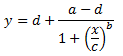

In [ ]:
thresholdCases = 1
countries = getListofSortedCountries(full_table, thresholdCases)
dfFullPivot = getPivotedCountryData(dfFullGB, countries)
dfCountryShifted = getShiftedPivotData(dfFullPivot, countries, thresholdCases)

fig = px.line(title="Logistic Curve Fitting by Country")
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]
# countries = getListofSortedCountries(full_table, 30)
df = pd.DataFrame(columns=['A','B','C','D','Country'])

i = 0
for country in countries:
    color = colors[i]
    i+=1
    if i == 10:
        i=0
    pop = dfDemographic[dfDemographic['Country/Region']==country]['Population(Millions)'].values[0]
    x = list(range(0,200,1))
    y_meas = dfCountryShifted[country].dropna().shift(0).values#/pop
    x1 = list(range(0,len(y_meas),1))
    p0 = [0.12921726,  4.20419294, 8.80087419, 30000.47285608]
    
#     print(country)
    if country == 'Diamond Princess':
        break

    # Fit equation using least squares optimization
    plsq = leastsq(residuals, p0, args=(y_meas, x1))
    df.loc[len(df)] = ['%.2f'%plsq[0][0],'%.2f'%plsq[0][1],'%.2f'%plsq[0][2],'%.2f'%plsq[0][3], country]
    fig.add_scatter(x=x, y=y_meas#*pop
                    ,mode='markers', name=getLegendGroup(country) + ' - ' + country,legendgroup=country,
                    visible = showOnly1Country(country,'US'),
                    line_color=color)
    fig.add_scatter(x=x, y= peval(x,plsq[0])#*pop
                    ,mode='lines',  name=getLegendGroup(country) + ' - ' + country,legendgroup=country,
                    visible = showOnly1Country(country,'US'), 
                    line_color=color)
# fig.update_layout( yaxis_type="log")
fig.update_layout(
    xaxis_title="Days Since " + str(thresholdCases) + " case",
    yaxis_title="Number of Cases",
)
fig.show()
df

In [ ]:
thresholdCases = 1
dfFullNotChina = dfFullGB[dfFullGB['Country/Region']!='Mainland China']
regions = getListofSortedRegions(dfFullNotChina, dfCI, thresholdCases)
dfFullPivotRegions = getPivotedRegionData(dfFullNotChina, regions)
dfRegionShifted = getShiftedPivotData(dfFullPivotRegions, regions, thresholdCases)

fig = px.line(title="Logistic Curve Fitting by Country (excl China)")
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]
df = pd.DataFrame(columns=['A','B','C','D','Country'])

i = 0
for region in regions:
    color = colors[i]
    i+=1
    if i == 10:
        i=0
#     pop = dfDemographicRegion[dfDemographicRegion['Region']==region]['Population(Millions)'].values[0]
    x = list(range(0,150,1))
    y_meas = dfRegionShifted[region].dropna().shift(0).values#/pop
    x1 = list(range(0,len(y_meas),1))
    p0 = [0.12921726,  4.20419294, 8.80087419, 30000.47285608]
    
    # Fit equation using least squares optimization
    plsq = leastsq(residuals, p0, args=(y_meas, x1))
    df.loc[len(df)] = ['%.2f'%plsq[0][0],'%.2f'%plsq[0][1],'%.2f'%plsq[0][2],'%.2f'%plsq[0][3], region]
    fig.add_scatter(x=x, y=y_meas,#*pop, 
                    mode='markers', name=region,legendgroup=region,
#                     visible = 'legendonly',
                    line_color=color)
    fig.add_scatter(x=x, y= peval(x,plsq[0]),#*pop, 
                    mode='lines',  name=region,legendgroup=region,
#                     visible = showOnly1Country(country,'UK'), 
                    line_color=color)
fig.update_layout(
    xaxis_title="Days Since " + str(thresholdCases) + " case",
    yaxis_title="Number of Cases",
)
fig.show()
df

References: 
* https://www.myassays.com/four-parameter-logistic-regression.html
    